<a href="https://colab.research.google.com/github/DavidBrynnHouse/Data-602/blob/main/Data602_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 602 Final Project: Fatal crashes in the District of Columbia

an explaination of the sttributes can be found here: https://www.arcgis.com/sharing/rest/content/items/70392a096a8e431381f1f692aaa06afd/info/metadata/metadata.xml?format=default&output=html

In [103]:
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [104]:
from google.colab import files
uploaded = files.upload()

I hope to be able to use the classifier to predict wheather a crash will be fatal or not.

In [105]:
df = pd.read_csv('Crashes_in_DC.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,X,Y,OBJECTID,CRIMEID,CCN,REPORTDATE,ROUTEID,MEASURE,OFFSET,STREETSEGID,ROADWAYSEGID,FROMDATE,TODATE,MARID,ADDRESS,LATITUDE,LONGITUDE,XCOORD,YCOORD,WARD,EVENTID,MAR_ADDRESS,MAR_SCORE,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_DRIVER,MINORINJURIES_DRIVER,UNKNOWNINJURIES_DRIVER,FATAL_DRIVER,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,PEDESTRIANSIMPAIRED,BICYCLISTSIMPAIRED,DRIVERSIMPAIRED,TOTAL_TAXIS,TOTAL_GOVERNMENT,SPEEDING_INVOLVED,NEARESTINTROUTEID,NEARESTINTSTREETNAME,OFFINTERSECTION,INTAPPROACHDIRECTION,LOCATIONERROR,LASTUPDATEDATE,MPDLATITUDE,MPDLONGITUDE,MPDGEOX,MPDGEOY,BLOCKKEY,SUBBLOCKKEY,FATALPASSENGER,MAJORINJURIESPASSENGER,MINORINJURIESPASSENGER,UNKNOWNINJURIESPASSENGER
0,-77.007754,38.835717,236633601,28838887,21099435,2021/07/19 20:55:29+00,15081252,6168.19,4.16,NaN,NaN,2021/07/18 04:00:00+00,NaN,150759,3800 SOUTH CAPITOL STREET SE,38.835286,-77.007896,399314.444,129721.582,Ward 8,{A3DCF2AF-4F4D-4339-A2AF-8B24266B37D6},3800 SOUTH CAPITOL STREET SE,200.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,13042702,HALLEY PL SE,2.60,North,NaN,2021/07/28 14:41:59+00,38.835699,-77.007798,399342.34,129714.17,NaN,NaN,0,0,0,0
1,-77.103886,38.939821,236633602,28838894,21099702,2021/07/19 21:01:27+00,0,0.00,6.58,NaN,NaN,2021/07/19 04:00:00+00,NaN,269074,DALECARLIA PARKWAY NW & ROCKWOOD PARKWAY NW,38.938911,-77.104038,390980.291,141229.839,Ward 3,{48F39B5A-16D5-4263-B635-43F07BEF5AB3},5165 ROCKWOOD PARKWAY NW,200.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Not Available,0.00,East,NaN,2021/07/28 14:42:00+00,38.939811,-77.103808,390980.29,141229.84,NaN,NaN,0,0,0,0
2,-77.031957,38.902531,236633603,28838911,21099802,2021/07/19 21:45:21+00,11001402,1455.41,0.01,NaN,NaN,2021/07/19 04:00:00+00,NaN,304721,K STREET NW & 14TH STREET NW,38.902523,-77.031955,397228.190,137185.830,Ward 2,{3BED82E6-029E-4D4A-874E-D5C45923ED3E},1375 K STREET NW,200.0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,21050893,K ST NW,12.66,South,NaN,2021/07/28 14:42:04+00,38.902523,-77.031955,397228.19,137185.83,NaN,NaN,0,0,0,0
3,-77.036076,38.933146,236633604,28838912,21099795,2021/07/19 21:49:09+00,11064612,460.57,6.96,NaN,NaN,2021/07/19 04:00:00+00,NaN,234537,1524 NEWTON STREET NW,38.932888,-77.035930,396884.752,140556.727,Ward 1,{4BF43E1D-4A34-4355-8341-F22F7DB20A67},1524 NEWTON STREET NW,200.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,58018582,Driveway-58018582,23.53,Northwest,NaN,2021/07/28 14:42:07+00,38.933082,-77.036109,396889.29,140554.49,NaN,NaN,0,0,0,0
4,-77.006367,38.908292,236633605,28838917,21099769,2021/07/19 21:55:42+00,0,0.00,3.48,NaN,NaN,2021/07/19 04:00:00+00,NaN,288940,75 NEW YORK AVENUE NE,38.907960,-77.005888,399489.348,137788.901,Ward 6,{EEF8100D-0CDF-49F5-9E4F-A88A9DE2B0BC},75 NEW YORK AVENUE NE,200.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,Not Available,0.00,East,NaN,2021/07/28 14:42:09+00,38.908255,-77.006349,399455.05,137789.00,NaN,NaN,0,0,0,0


Many of the attributes indicate the location of the crash. To prevent multi-colinearity I will only use the X and Y coordinates provided. There are also many attributes such as ObjectID which provide no relevant information which I will remove.

In [106]:
del df['X']
del df['Y']
del df['LATITUDE']
del df['LONGITUDE']
del df['REPORTDATE']
del df['OBJECTID']
del df['CRIMEID']
del df['CCN']
del df['ROUTEID']
del df['MEASURE']
del df['OFFSET']
del df['STREETSEGID']
del df['ROADWAYSEGID']
del df['TODATE']
del df['MARID']
del df['ADDRESS']
del df['EVENTID']
del df['MAR_SCORE']
del df['MAR_ADDRESS']
del df['NEARESTINTROUTEID']
del df['NEARESTINTSTREETNAME']
del df['LOCATIONERROR']
del df['LASTUPDATEDATE']
del df['MPDLATITUDE']
del df['MPDLONGITUDE']
del df['MPDGEOX']
del df['MPDGEOY']
del df['BLOCKKEY']
del df['SUBBLOCKKEY']
del df['WARD']
del df['FROMDATE']

df.head()

,XCOORD,YCOORD,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_DRIVER,MINORINJURIES_DRIVER,UNKNOWNINJURIES_DRIVER,FATAL_DRIVER,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,PEDESTRIANSIMPAIRED,BICYCLISTSIMPAIRED,DRIVERSIMPAIRED,TOTAL_TAXIS,TOTAL_GOVERNMENT,SPEEDING_INVOLVED,OFFINTERSECTION,INTAPPROACHDIRECTION,FATALPASSENGER,MAJORINJURIESPASSENGER,MINORINJURIESPASSENGER,UNKNOWNINJURIESPASSENGER
0,399314.444,129721.582,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2.60,North,0,0,0,0
1,390980.291,141229.839,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.00,East,0,0,0,0
2,397228.190,137185.830,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,12.66,South,0,0,0,0
3,396884.752,140556.727,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,23.53,Northwest,0,0,0,0
4,399489.348,137788.901,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0.00,East,0,0,0,0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259374 entries, 0 to 259373
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   XCOORD                      259374 non-null  float64
 1   YCOORD                      259374 non-null  float64
 2   MAJORINJURIES_BICYCLIST     259374 non-null  int64  
 3   MINORINJURIES_BICYCLIST     259374 non-null  int64  
 4   UNKNOWNINJURIES_BICYCLIST   259374 non-null  int64  
 5   FATAL_BICYCLIST             259374 non-null  int64  
 6   MAJORINJURIES_DRIVER        259374 non-null  int64  
 7   MINORINJURIES_DRIVER        259374 non-null  int64  
 8   UNKNOWNINJURIES_DRIVER      259374 non-null  int64  
 9   FATAL_DRIVER                259374 non-null  int64  
 10  MAJORINJURIES_PEDESTRIAN    259374 non-null  int64  
 11  MINORINJURIES_PEDESTRIAN    259374 non-null  int64  
 12  UNKNOWNINJURIES_PEDESTRIAN  259374 non-null  int64  
 13  FATAL_PEDESTRI

As we can see above there are several categorical features which will need to be dealt with. Finally, there is no need to distinguish between what kind of fatality/ injury so I will just sum those up and put them in their own respective features.

In [108]:
df['FATALITIES'] = df['FATAL_DRIVER'] + df['FATAL_BICYCLIST'] + df['FATAL_PEDESTRIAN'] + df['FATALPASSENGER']
del df['FATAL_DRIVER'] 
del df['FATAL_BICYCLIST'] 
del df['FATAL_PEDESTRIAN'] 
del df['FATALPASSENGER']
df.head()

,XCOORD,YCOORD,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,MAJORINJURIES_DRIVER,MINORINJURIES_DRIVER,UNKNOWNINJURIES_DRIVER,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,PEDESTRIANSIMPAIRED,BICYCLISTSIMPAIRED,DRIVERSIMPAIRED,TOTAL_TAXIS,TOTAL_GOVERNMENT,SPEEDING_INVOLVED,OFFINTERSECTION,INTAPPROACHDIRECTION,MAJORINJURIESPASSENGER,MINORINJURIESPASSENGER,UNKNOWNINJURIESPASSENGER,FATALITIES
0,399314.444,129721.582,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2.60,North,0,0,0,0
1,390980.291,141229.839,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.00,East,0,0,0,0
2,397228.190,137185.830,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,12.66,South,0,0,0,0
3,396884.752,140556.727,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,23.53,Northwest,0,0,0,0
4,399489.348,137788.901,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0.00,East,0,0,0,0


Because we are only interested in wheather or not there was a fatality we want to convert the FATALITIES field into a 1 or 0.

In [109]:
df['FATALITIES'] = df['FATALITIES'].where(df['FATALITIES'] < 1, 1)
df['FATALITIES'].value_counts()

0    258866
1       508
Name: FATALITIES, dtype: int64

In [110]:
df['INJURIES'] = df['MAJORINJURIES_BICYCLIST'] + df['MINORINJURIES_BICYCLIST'] + df['UNKNOWNINJURIES_BICYCLIST'] + df['MAJORINJURIES_DRIVER'] + df['MINORINJURIES_DRIVER'] + df['UNKNOWNINJURIES_DRIVER'] + df['MAJORINJURIES_PEDESTRIAN'] + df['MINORINJURIES_PEDESTRIAN'] + df['UNKNOWNINJURIES_PEDESTRIAN'] + df['MAJORINJURIESPASSENGER'] + df['MINORINJURIESPASSENGER'] + df['UNKNOWNINJURIESPASSENGER']
del df['MAJORINJURIES_BICYCLIST'] 
del df['MINORINJURIES_BICYCLIST'] 
del df['UNKNOWNINJURIES_BICYCLIST'] 
del df['MAJORINJURIES_DRIVER'] 
del df['MINORINJURIES_DRIVER'] 
del df['UNKNOWNINJURIES_DRIVER'] 
del df['MAJORINJURIES_PEDESTRIAN'] 
del df['MINORINJURIES_PEDESTRIAN'] 
del df['UNKNOWNINJURIES_PEDESTRIAN'] 
del df['MAJORINJURIESPASSENGER'] 
del df['MINORINJURIESPASSENGER'] 
del df['UNKNOWNINJURIESPASSENGER'] 
df.head()

,XCOORD,YCOORD,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,PEDESTRIANSIMPAIRED,BICYCLISTSIMPAIRED,DRIVERSIMPAIRED,TOTAL_TAXIS,TOTAL_GOVERNMENT,SPEEDING_INVOLVED,OFFINTERSECTION,INTAPPROACHDIRECTION,FATALITIES,INJURIES
0,399314.444,129721.582,2,0,0,0,0,0,0,0,0,2.60,North,0,0
1,390980.291,141229.839,1,0,0,0,0,0,0,0,0,0.00,East,0,1
2,397228.190,137185.830,2,0,0,0,0,0,0,0,0,12.66,South,0,1
3,396884.752,140556.727,2,0,0,0,0,0,0,0,0,23.53,Northwest,0,0
4,399489.348,137788.901,2,0,0,0,0,0,0,1,0,0.00,East,0,0


In [111]:
# one hot encode our categorical variable
df = pd.get_dummies(df , columns=['INTAPPROACHDIRECTION'])

Because our data is so unbalanced I want to undersample the data for later training.

In [112]:
class_zero = df[df['FATALITIES'] == 0]
class_one = df[df['FATALITIES'] == 1]

class_zero = class_zero.sample(len(class_one))
df_undersample = pd.concat([class_one, class_zero])
df_undersample

,XCOORD,YCOORD,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,PEDESTRIANSIMPAIRED,BICYCLISTSIMPAIRED,DRIVERSIMPAIRED,TOTAL_TAXIS,TOTAL_GOVERNMENT,SPEEDING_INVOLVED,OFFINTERSECTION,FATALITIES,INJURIES,INTAPPROACHDIRECTION_East,INTAPPROACHDIRECTION_North,INTAPPROACHDIRECTION_Northeast,INTAPPROACHDIRECTION_Northwest,INTAPPROACHDIRECTION_South,INTAPPROACHDIRECTION_Southeast,INTAPPROACHDIRECTION_Southwest,INTAPPROACHDIRECTION_Unknown,INTAPPROACHDIRECTION_West
147,400638.752,132748.230,2,0,0,0,0,0,0,0,0,0.00,1,0,1,0,0,0,0,0,0,0,0
1434,399813.992,129799.650,2,0,0,0,0,0,0,0,0,81.73,1,0,0,0,0,0,0,0,1,0,0
1623,399244.809,143262.462,1,0,0,0,0,0,0,0,0,49.12,1,0,0,0,0,0,1,0,0,0,0
1838,398087.686,144264.729,2,0,0,0,0,0,0,0,1,33.09,1,0,1,0,0,0,0,0,0,0,0
2050,398299.387,138602.717,3,0,0,0,0,0,0,1,0,28.22,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228278,396642.978,137744.686,2,0,0,0,0,0,0,0,0,5.53,0,1,0,1,0,0,0,0,0,0,0
15997,401944.400,141039.020,2,0,0,0,0,0,0,0,0,7.81,0,1,0,0,0,0,0,1,0,0,0
194423,395102.153,136452.657,2,0,0,0,0,0,0,0,0,0.00,0,0,1,0,0,0,0,0,0,0,0
165606,397325.903,139919.636,2,0,0,0,0,0,0,0,0,99.87,0,0,0,0,0,0,0,0,0,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbea6eee3d0>,
      dtype=object)

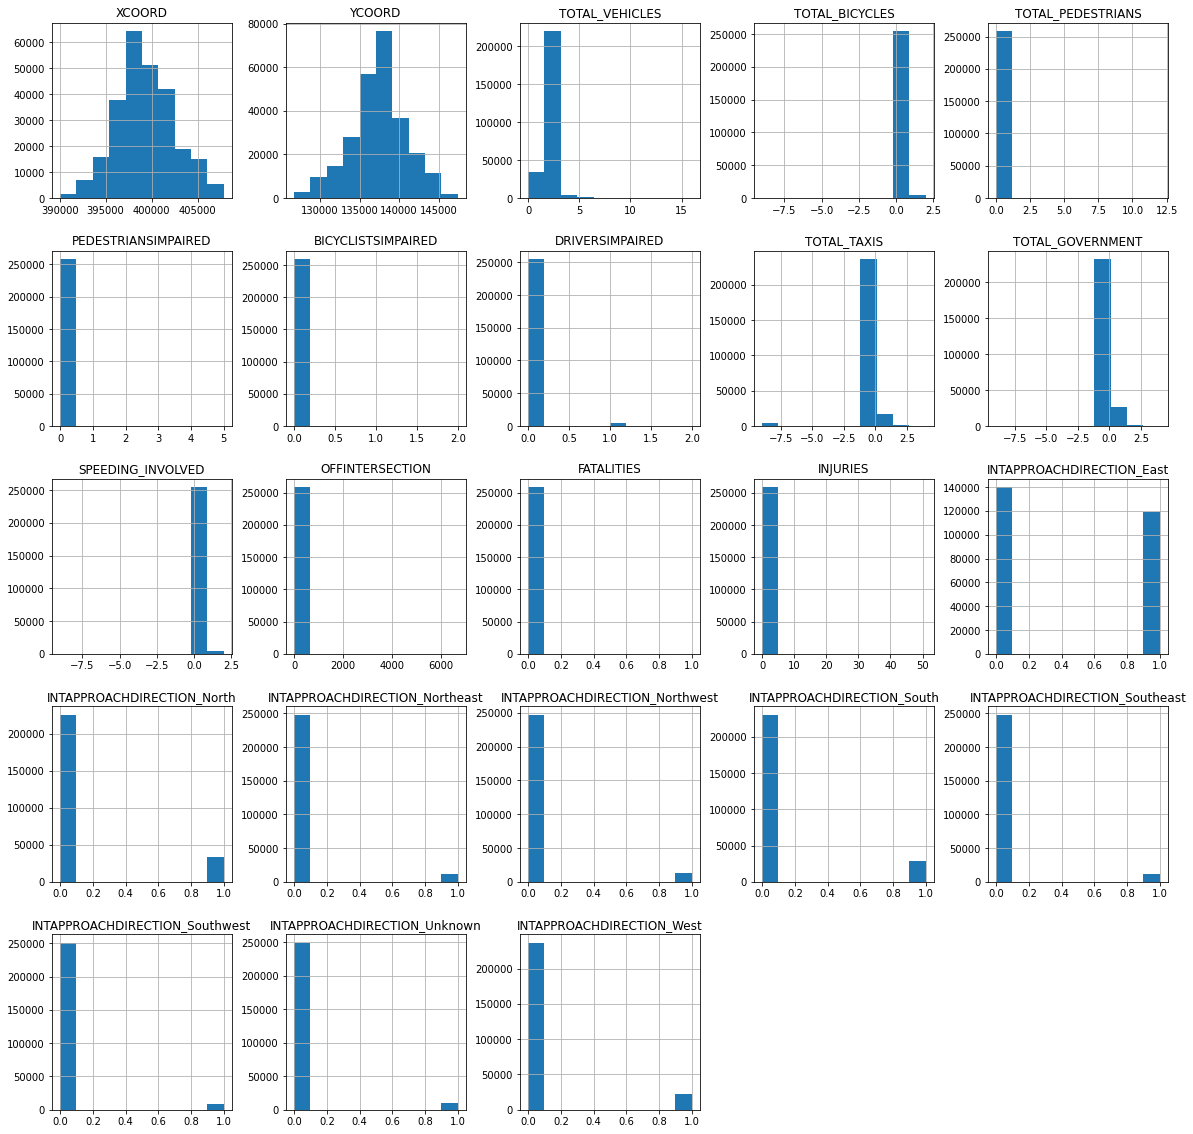

In [113]:
df.hist(figsize=(20, 20))

In [114]:
# Split data into training, validation, and testing sets where train is 60% val is 20% and test is 20%

def train_val_test(df, test_size=0.2):
    """
    arguments:
    df: data frame to be split into training test and validation sets
    test_size: percent of dataframe to be allocated to test and validation sets

    returns:
    X_train: Features to train model on
    X_val: Features of validation set
    X_test: Features of test set

    y_train: classes to train on
    y_val: classes of validation set
    y_test: classes of test set
    """
    df.sample(frac=1).reset_index(drop=True)
    train, test = train_test_split(df, test_size=test_size)
    train, val = train_test_split(train, test_size=test_size)

    y_train = np.array(train.pop('FATALITIES'))
    y_val = np.array(val.pop('FATALITIES'))
    y_test = np.array(test.pop('FATALITIES'))

    X_train = np.array(train)
    X_val = np.array(val)
    X_test = np.array(test)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [115]:
from tensorflow.keras import regularizers

METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.Accuracy(name='accuracy')
]

def make_model(metrics=METRICS, learning_rate=0.005):
    """
    used to create a deep nn with keras
    attributes:
    metrics: List of metrics from keras to measure the performance of the model
    learning_rate: the learning rate used for optimization

    returns the trained model
    """
    model = keras.Sequential([
        keras.layers.Dense(
            32, 
            kernel_initializer='random_normal',
            activation='relu',
            input_shape=(X_train.shape[-1],),),
        keras.layers.Dropout(.2),
        keras.layers.Dense(1, activation='sigmoid')

    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model


In [131]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df_undersample, 0.2)

In [132]:
model = make_model()
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                736       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [133]:
model = make_model(learning_rate=.05)
history = model.fit(
    X_train,
    y_train,
    batch_size=4096,
    epochs=100,
    validation_data=(X_val, y_val))


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7042 - precision: 0.4759 - recall: 0.6330 - accuracy: 2.1353e-04 - val_loss: 0.6066 - val_precision: 0.7222 - val_recall: 0.6265 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.6359 - precision: 0.7178 - recall: 0.4503 - accuracy: 0.0000e+00 - val_loss: 0.5738 - val_precision: 0.7200 - val_recall: 0.6506 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.6092 - precision: 0.7189 - recall: 0.5559 - accuracy: 0.0000e+00 - val_loss: 0.5586 - val_precision: 0.7237 - val_recall: 0.6627 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 0.5921 - precision: 0.7206 - recall: 0.5528 - accuracy: 0.0000e+00 - val_loss: 0.5525 - val_precision: 0.7571 - val_recall: 0.6386 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 0.5807 - p

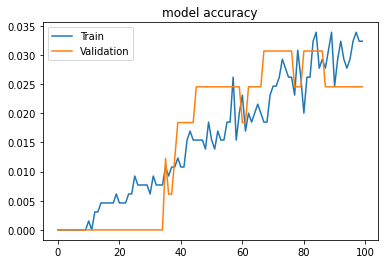

In [119]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


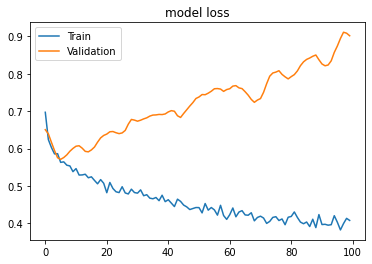

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

I was unable to reduce over fitting with this model, Even with a balanced data set the accuracy was just too low for this to be a realistic model.

In [121]:
def grid_classifier(model, params):
    """
    used to fit multiple classifiers quickly so that I can test them with grid search
    attributes:
    model: What model to train
    params: dictionary containing parameters and values to test with grid search
    returns:
    nothing, but prints best estimator and its score
    """
    cv = GridSearchCV(clf,parameters,cv=5)
    cv.fit(X_train, y_train)
    print(cv.best_estimator_)
    print(cv.best_score_)

In [122]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

clf = svm.SVC()
parameters = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "C":[0.001, 0.01, 0.1, 10]
}
grid_classifier(clf, parameters)

SVC(C=0.01, kernel='linear')
0.6579487179487179


In [123]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
parameters = {
    "max_depth": [2, 10, 100, 1000, None],
    "n_estimators": [1, 10, 100, 1000]
}
grid_classifier(clf, parameters)

RandomForestClassifier(max_depth=2, n_estimators=1000)
0.6887418008348241


In [124]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
parameters = {
    "C": [0.01, 0.1, 1, 10, 100]
    }
grid_classifier(clf, parameters)

LogisticRegression(C=10, random_state=0)
0.6594156231365534


In [125]:
clf = RandomForestClassifier(max_depth=1000, n_estimators=10)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.6380368098159509

In [126]:
from sklearn.metrics import classification_report
y_val_pred = clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.60      0.73      0.66        78
           1       0.69      0.55      0.61        85

    accuracy                           0.64       163
   macro avg       0.65      0.64      0.64       163
weighted avg       0.65      0.64      0.64       163



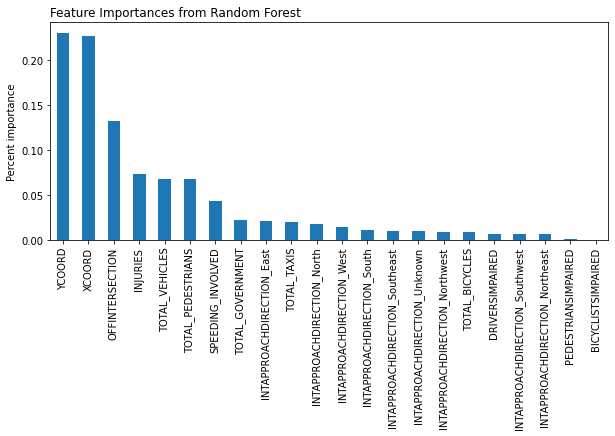

In [127]:
impt = clf.feature_importances_

feature_names = df.columns.values.tolist()
feature_names.remove('FATALITIES')
tick_locations = [*range(0, len(feature_names), 1)]
impt = list(zip(feature_names, impt))
impt = pd.DataFrame(impt)
impt.columns = ['feature', 'importance']
impt = impt.sort_values(by='importance', ascending=False)

impt.plot.bar(figsize=(10,4))
plt.title('Feature Importances from Random Forest', loc='left')
plt.xlabel('')
plt.ylabel('Percent importance')
plt.xticks(tick_locations, impt.feature)
plt.legend().remove()
plt.show()